In [1]:
%matplotlib inline
import cosima_cookbook as cc
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap, shiftgrid
import numpy as np
import netCDF4 as nc
import xarray as xr
import cmocean as cm
import cartopy
import cartopy.crs as ccrs
import pandas as pd
import copy
import math
from collections import OrderedDict
import IPython.display
# import seaborn as sns
from glob import glob
import scipy as sp
import scipy.interpolate
import scipy.ndimage
from tqdm import tqdm_notebook
import IPython.display
import cmocean as cm
from scipy.io import loadmat
from dask.distributed import Client
import cartopy.feature as cft
import matplotlib.ticker as mticker
import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))  # so we can import ../exptdata
import exptdata
import matplotlib
import warnings
import cftime
print('Available exptdata keys: ', [k for k in exptdata.exptdict.keys()])

Available exptdata keys:  ['1deg', '025deg', '025deg_abs', '01deg']


In [2]:
figdir = ''
def savefigure(fname):
    plt.savefig(os.path.join(figdir, fname+'.png'),dpi=300, bbox_inches="tight")  # comment out to disable saving
    plt.savefig(os.path.join(figdir, fname+'.pdf'),dpi=300, bbox_inches="tight")  # comment out to disable saving
    return

In [3]:
# for plots
font = { 'family' : 'normal',
         'weight' : 'bold',
         'size'   : 16 }
matplotlib.rc('font', **font)
land_50m = cft.NaturalEarthFeature('physical','land','110m',edgecolor='black',facecolor='gray',linewidth=0.5)

In [4]:
transects = OrderedDict([ # use OrderedDict so panels are produced in a reproducible order
            ('AB', [148-360, 150-360, -43, -43]),
            ('BC', [150-360, 170.5-360,-43,-43]),
            ('FE', [153.5-360,155.7-360,-28,-28]),
            ('ED', [155.7-360,173-360,-28,-28]),
            ('HI', [146.5-360,146.5-360,-46,-43.5]),
            ('DG', [173-360,173-360,-34.4,-28])])
      
points = OrderedDict([
                   ('A',[148,-43]),
                   ('B',[150,-43]),
                   ('C',[170.5,-43]),
                   ('D',[173,-28]),
                   ('E',[155.7,-28]),
                   ('F',[153.5,-28]),
                   ('G',[173,-34.4]),
                   ('H',[146.5,-43.5]),
                   ('I',[146.5,-46])
                  ])
    
region=[145-360,174-360,-48,-20]

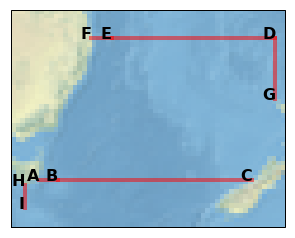

In [24]:
warnings.filterwarnings('ignore')
ax = plt.axes(projection=ccrs.PlateCarree())
ax.stock_img()
ax.set_xlim(145, 174)
ax.set_ylim(-48,-25)
for transect, (xmin, xmax, ymin, ymax) in transects.items():

    plt.plot([xmin, xmax], [ymin, ymax],
            color='red', linewidth=4, alpha=0.5,
             transform=ccrs.Geodetic() )

for point, (xi,yi) in points.items():
    plt.text(xi,yi,point,
            horizontalalignment='right',transform=ccrs.Geodetic())

In [5]:
session = cc.database.create_session()

In [6]:
t=slice(cftime.DatetimeGregorian(1993,1,1),None)

In [7]:
plotexp=['1deg','025deg','01deg']
clev = np.arange(-3.5,3.51,0.1)
clev2 = np.arange(-1.5,1.6,0.5)

Text(0,0.5,'Sv')

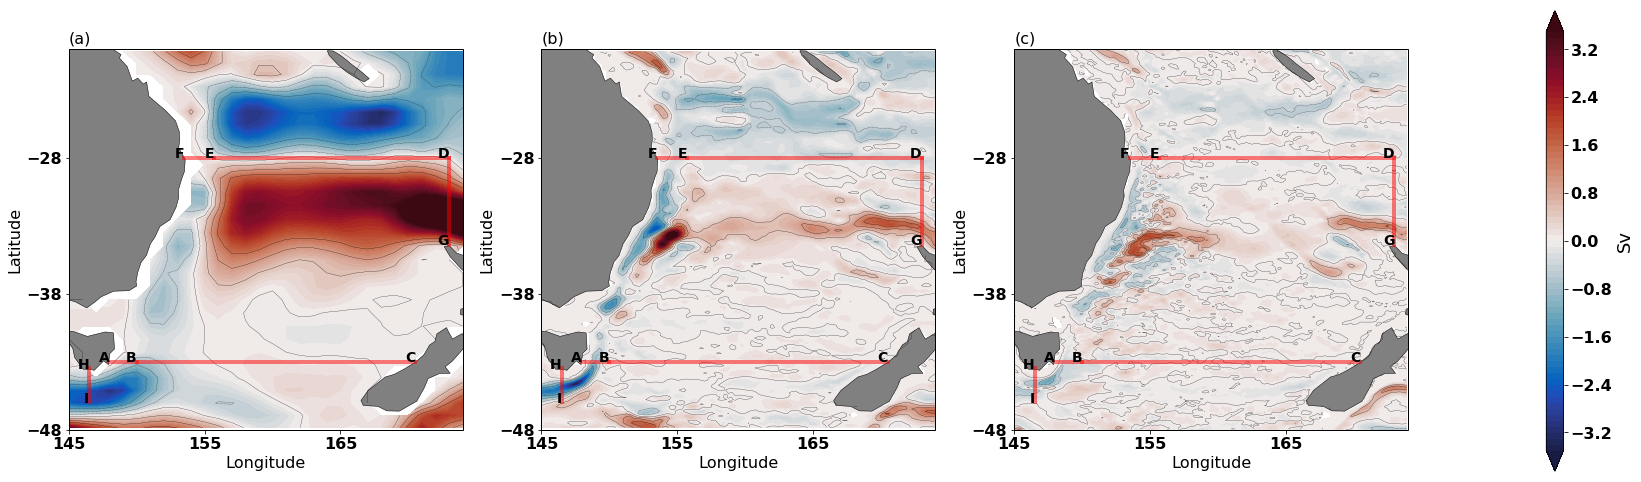

In [31]:
warnings.filterwarnings('ignore')
fig=plt.figure(figsize=(24,8))
for i,ekey in enumerate(plotexp):
    expt = exptdata.exptdict[ekey]['expt']
    n = exptdata.exptdict[ekey]['n_files']
    offset = exptdata.exptdict[ekey]['offset']
    tx_trans=cc.querying.getvar(expt,'tx_trans_int_z',session,n=n,
                                     offset=offset)
    transport=tx_trans.sel(xu_ocean=slice(region[0],region[1]))\
                      .sel(yt_ocean=slice(region[2],region[3])).sel(time=t)\
                      .mean('time')/1e6/1036
    ax=plt.subplot(1,3,i+1,projection=ccrs.PlateCarree())
    ax.add_feature(land_50m)
    ax.set_extent(region,crs=ccrs.PlateCarree())
    ax.set_xticks(np.arange(region[0],region[1]+1,10)+360,crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(region[2],region[3],10),crs=ccrs.PlateCarree())
    p1=transport.plot.contourf(cmap=cm.cm.balance, levels=clev, extend='both',add_colorbar=False)
    transport.plot.contour(levels=clev2,colors='k',linewidths=0.25,transform=ccrs.PlateCarree())
    for transect, (xmin, xmax, ymin, ymax) in transects.items():

        plt.plot([xmin, xmax], [ymin, ymax],
                color='red', linewidth=4, alpha=0.5,
                 transform=ccrs.Geodetic() )

    for point, (xi,yi) in points.items():
        plt.text(xi,yi,point,
                horizontalalignment='right',transform=ccrs.Geodetic(),fontsize=14)
    plt.xlabel('Longitude',fontsize=16)
    plt.ylabel('Latitude',fontsize=16)
    plt.title('')
    plt.title('('+chr(i+ord('a'))+')',loc='left',fontsize=16)
ax3 = plt.axes([0.98,0.1,0.01,0.8])
cb = plt.colorbar(p1,cax=ax3,orientation='vertical')
cb.ax.set_ylabel('Sv',fontsize=18)
#savefigure('transport')

# Transport through each transect (full depth)

In [11]:
def transport(ekey,transect):
    expt = exptdata.exptdict[ekey]['expt']
    n = exptdata.exptdict[ekey]['n_files']
    offset = exptdata.exptdict[ekey]['offset']
    xmin=transects[transect][0]
    xmax=transects[transect][1]
    ymin=transects[transect][2]
    ymax=transects[transect][3]
    if xmin==xmax:
        tx_trans=cc.querying.getvar(expt,'tx_trans_int_z',session,n=n,
                                 offset=offset)
        transport=tx_trans.sel(xu_ocean=xmin,method='nearest')\
                          .sel(yt_ocean=slice(ymin,ymax)).sel(time=t)\
                          .sum('yt_ocean').mean('time')/1e6/1036
    elif ymin==ymax:
        ty_trans = cc.querying.getvar(expt,'ty_trans_int_z',session,n=n,
                                 offset=offset)
        transport=ty_trans.sel(yu_ocean=ymin,method='nearest')\
                          .sel(xt_ocean=slice(xmin,xmax)).sel(time=t)\
                          .sum('xt_ocean').mean('time')/1e6/1036
    return transport

In [43]:
result=np.full([4,6],np.nan)
for i,ekey in enumerate(exptdata.exptdict):
    for j,transect in enumerate(transects):
        transp=transport(ekey,transect)
        result[i,j]=transp
        print('calculating transect',transect,'for',ekey)
Transp=pd.DataFrame(result, columns=['AB','BC','FE','ED','HI','DG'])
Transp.rename(index={0:'1deg',1:'025deg',2:'025deg_abs',3:'01deg'},inplace=True)

calculating transect AB for 1deg
calculating transect BC for 1deg
calculating transect FE for 1deg
calculating transect ED for 1deg
calculating transect HI for 1deg
calculating transect DG for 1deg
calculating transect AB for 025deg
calculating transect BC for 025deg
calculating transect FE for 025deg
calculating transect ED for 025deg
calculating transect HI for 025deg
calculating transect DG for 025deg
calculating transect AB for 025deg_abs
calculating transect BC for 025deg_abs
calculating transect FE for 025deg_abs
calculating transect ED for 025deg_abs
calculating transect HI for 025deg_abs
calculating transect DG for 025deg_abs
calculating transect AB for 01deg
calculating transect BC for 01deg
calculating transect FE for 01deg
calculating transect ED for 01deg
calculating transect HI for 01deg
calculating transect DG for 01deg


In [44]:
Transp

,AB,BC,FE,ED,HI,DG
1deg,-1.092090,0.386201,-12.728683,-5.644761,-3.367160,17.771292
025deg,-9.606915,4.769818,-15.088259,2.859633,-11.519571,7.165773
025deg_abs,-10.099075,4.972256,-15.452668,2.707158,-11.261584,7.376211
01deg,-8.030404,2.902781,-15.198821,3.249483,-11.150938,6.647566


# Transport through each transect (upper 2km)

In [12]:
def transport_up2(ekey,transect):
    expt = exptdata.exptdict[ekey]['expt']
    n = exptdata.exptdict[ekey]['n_files']
    offset = exptdata.exptdict[ekey]['offset']
    xmin=transects[transect][0]
    xmax=transects[transect][1]
    ymin=transects[transect][2]
    ymax=transects[transect][3]
    if xmin==xmax:
        tx_trans=cc.querying.getvar(expt,'tx_trans',session,n=n,
                                 offset=offset)
        transport=tx_trans.sel(xu_ocean=xmin,method='nearest')\
                          .sel(yt_ocean=slice(ymin,ymax)).sel(time=t)\
                          .sel(st_ocean=slice(0,2000)).sum('st_ocean')\
                          .sum('yt_ocean').mean('time')/1e6/1036
    elif ymin==ymax:
        ty_trans = cc.querying.getvar(expt,'ty_trans',session,n=n,
                                 offset=offset)
        transport=ty_trans.sel(yu_ocean=ymin,method='nearest')\
                          .sel(xt_ocean=slice(xmin,xmax)).sel(time=t)\
                          .sel(st_ocean=slice(0,2000)).sum('st_ocean')\
                          .sum('xt_ocean').mean('time')/1e6/1036
    return transport

In [46]:
result_up2=np.full([4,6],np.nan)
for i,ekey in enumerate(exptdata.exptdict):
    for j,transect in enumerate(transects):
        print('calculating transect',transect,'for',ekey)
        transp=transport_up2(ekey,transect)
        result_up2[i,j]=transp
Transp_up2=pd.DataFrame(result_up2, columns=['AB','BC','FE','ED','HI','DG'])
Transp_up2.rename(index={0:'1deg',1:'025deg',2:'025deg_abs',3:'01deg'},inplace=True)

calculating transect AB for 1deg
calculating transect BC for 1deg
calculating transect FE for 1deg
calculating transect ED for 1deg
calculating transect HI for 1deg
calculating transect DG for 1deg
calculating transect AB for 025deg
calculating transect BC for 025deg
calculating transect FE for 025deg
calculating transect ED for 025deg
calculating transect HI for 025deg
calculating transect DG for 025deg
calculating transect AB for 025deg_abs
calculating transect BC for 025deg_abs
calculating transect FE for 025deg_abs
calculating transect ED for 025deg_abs
calculating transect HI for 025deg_abs
calculating transect DG for 025deg_abs
calculating transect AB for 01deg
calculating transect BC for 01deg
calculating transect FE for 01deg
calculating transect ED for 01deg
calculating transect HI for 01deg
calculating transect DG for 01deg


In [47]:
Transp_up2

,AB,BC,FE,ED,HI,DG
1deg,-1.082035,0.244494,-12.719374,-5.133369,-3.357739,17.650322
025deg,-10.458395,4.758357,-15.781631,3.336036,-12.157877,6.978923
025deg_abs,-10.884975,4.850808,-16.249161,3.276745,-12.145791,7.189581
01deg,-9.480373,2.743385,-17.229729,4.269335,-12.412681,6.551454


# Southward transport full and upper 2km

In [10]:
FD=[153.3-360,173-360,-28,-28]
#transects.update([('FD', [153.3-360,173-360,-28,-28])])
grid1=xr.open_dataset('/g/data3/hh5/tmp/cosima/access-om2/1deg_jra55v13_iaf_spinup1_A/output012/ocean/ocean_grid.nc')
grid025=xr.open_dataset('/g/data3/hh5/tmp/cosima/access-om2-025/025deg_jra55v13_iaf_gmredi6/output045/ocean/ocean_grid.nc')
grid01 = xr.open_dataset('/g/data3/hh5/tmp/cosima/access-om2-01/01deg_jra55v13_iaf/output120/ocean/ocean_grid.nc')

gridx=np.empty((3,1))
gridx[0]=grid1.dxt.sel(yt_ocean=-28,method='nearest').values[1]
gridx[1]=grid025.dxt.sel(yt_ocean=-28,method='nearest').values[1]
gridx[2]=grid01.dxt.sel(yt_ocean=-28,method='nearest').values[1]

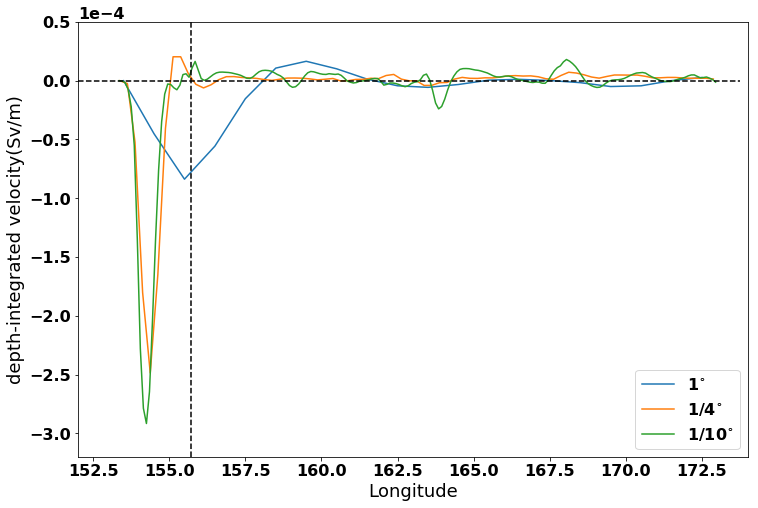

In [15]:
warnings.filterwarnings('ignore')
#upper 2km
fig=plt.figure(figsize=(12,8))
for i,ekey in enumerate(plotexp):
    expt = exptdata.exptdict[ekey]['expt']
    n = exptdata.exptdict[ekey]['n_files']
    offset = exptdata.exptdict[ekey]['offset']
    xmin=FD[0]
    xmax=FD[1]
    ymin=FD[2]
    ymax=FD[3]
    #ty_trans = cc.querying.getvar(expt,'ty_trans_int_z',session,n=n,
                                 #offset=offset)
    ty_trans = cc.querying.getvar(expt,'ty_trans',session,n=n,
                                 offset=offset).sel(st_ocean=slice(0,2000)).sum('st_ocean')
    transp=ty_trans.sel(yu_ocean=ymin,method='nearest')\
                      .sel(xt_ocean=slice(xmin,xmax)).sel(time=t)\
                      .mean('time')/1e6/1036
    #transcumsum=transp.cumsum('xt_ocean')
    #width=transcumsum.where(transcumsum==transcumsum.min().values,drop=True).xt_ocean.values[0]
    #southtrans=transp.sel(xt_ocean=slice(xmin,width)).sum('xt_ocean')
    #print('southward width for',ekey,'is',width+360,'and transport is',southtrans.values,'Sv')
    plt.plot(transp['xt_ocean']+360,transp.values/gridx[i])
plt.legend(['1$^{\circ}$','1/4$^{\circ}$','1/10$^{\circ}$'])
plt.plot((np.full(transp.shape,155.7)),np.linspace(-3.2e-4,5e-5,transp.shape[0]),'k--')
x0=np.arange(152,174,0.25)
plt.plot(x0,np.tile(0,x0.shape),'k--')
plt.ylim(-3.2e-4,5e-5)
plt.xlim(152,174)
ax = plt.gca() 
ax.ticklabel_format(style='sci', axis='y') 
ax.yaxis.major.formatter.set_powerlimits((0,0)) 
plt.ylabel('depth-integrated velocity(Sv/m)',fontsize=18)
plt.xlabel('Longitude',fontsize=18)
savefigure('transprof')

## Compare velocity profile with Sloyan et al 2016

In [16]:
#choose new time intervel to compare with Sloyan et al 2016
tvel=slice(cftime.DatetimeGregorian(2012,4,1),cftime.DatetimeGregorian(2013,9,1))

In [17]:
ekey='01deg'
expt=exptdata.exptdict[ekey]['expt']
n_files = exptdata.exptdict[ekey]['n_files']
offset = exptdata.exptdict[ekey]['offset']
v = cc.querying.getvar(expt,'v',session,
                                 n=n_files,offset=offset)\
                                 .sel(xu_ocean=slice(153.5-360,155.5-360))\
                                 .sel(yu_ocean=-27,method='nearest').sel(time=tvel)

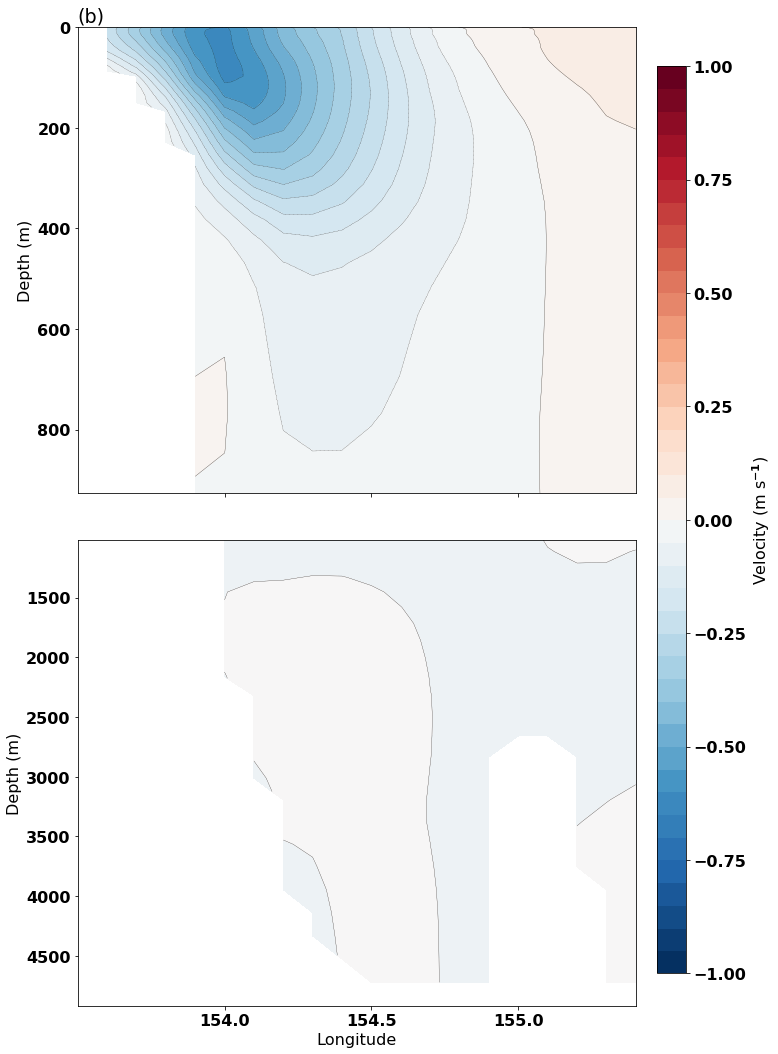

In [19]:
warnings.filterwarnings('ignore')
fig=plt.figure(figsize=(10,18))
v01mean=v.sel(st_ocean=slice(0,1000)).mean('time')
v01mean['Longitude']=v01mean['xu_ocean']+360
ax1=plt.subplot(2,1,1)
p1=v01mean.plot.contourf(x='Longitude',y='st_ocean',yincrease=False,add_colorbar=False, levels=np.arange(-1,1.05,0.05))
v01mean.plot.contour(x='Longitude',y='st_ocean',yincrease=False,add_colorbar=False,levels=np.arange(-1,1.1,0.05),colors='k',linewidths=0.25)
plt.ylabel("Depth (m)")
plt.xlabel('')
plt.title('')
plt.title('(b)',loc='left')
ax1.set_xticks([154,154.5,155])
plt.setp(ax1.get_xticklabels(), visible=False)
#ax1.set_title('01deg upper 1km')
ax2 = plt.subplot(2,1,2)
v01mean=v.sel(st_ocean=slice(1000,5000)).mean('time')
v01mean['Longitude']=v01mean['xu_ocean']+360
p2=v01mean.plot.contourf(x='Longitude',y='st_ocean',yincrease=False,add_colorbar=False,levels=np.arange(-1,1.1,0.05))
v01mean.plot.contour(x='Longitude',y='st_ocean',yincrease=False,add_colorbar=False,levels=np.arange(-1,1.1,0.05),colors='k',linewidths=0.25)
ax2.set_xticks([154,154.5,155])
plt.ylabel('Depth (m)')
plt.title('')
#ax2.set_title('01deg under 1km')
ax3=plt.axes([0.93,0.15,0.04,0.7])
cb=plt.colorbar(p1,cax=ax3,orientation='vertical')
cb.ax.set_ylabel('Velocity (m s$^{-1}$)')
plt.subplots_adjust(left=None, bottom=None, right=None, top=None,wspace=None, hspace=0.1)
savefigure('alongslope')

### Velocity shear in comparison with Archer et al 2017

In [14]:
omega=7.292e-5
theta=-30.27*math.pi/180
f=2*omega*np.sin(theta)

In [16]:
tshear=slice(cftime.DatetimeGregorian(2012,3,1),cftime.DatetimeGregorian(2016,8,1))
ekey='01deg'
expt=exptdata.exptdict[ekey]['expt']
n_files = exptdata.exptdict[ekey]['n_files']
offset = exptdata.exptdict[ekey]['offset']
v = cc.querying.getvar(expt,'v',session,
                                 n=n_files,offset=offset)\
                                 .sel(xu_ocean=slice(153.5-360,155.5-360))\
                                 .sel(yu_ocean=slice(-30.3,-30.15)).sel(time=tshear)

In [17]:
dxt=grid01.dxt.sel(xt_ocean=slice(153.5-360,155.5-360))\
            .sel(yt_ocean=-30.27,method='nearest')
dxtnew=dxt[0:-1]
vnew=v.mean('time').sel(st_ocean=0.9,method='nearest')
dv=vnew.values[:,1:]-vnew.values[:,0:-1]
dvmean=0.5*(dv[1:,:]+dv[0:-1,:])
dvmean1=dvmean.transpose().squeeze()
shear=xr.DataArray(dvmean1/(dxtnew.values*abs(f)),coords=dxtnew.coords)

In [18]:
dx=dxtnew.values[0]
l=len(dxtnew)
distance0=np.arange(0,l*dx,dx)
distance=np.around((distance0-distance0[3])/1e3,decimals=0)
shear_discor=shear
shear_discor=shear_discor.assign_coords(xt_ocean=distance)

Text(0.5,0,'Cross-jet distance (km)')

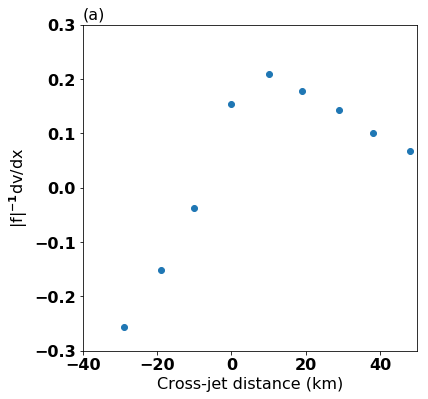

In [19]:
plt.figure(figsize=(6,6))
plt.plot(shear_discor.xt_ocean.values,shear_discor.values,'o')
plt.xlim([-40,50])
plt.ylim([-0.3,0.3])
plt.title('(a)',loc='left',fontsize=16)
plt.ylabel('|f|$^{-1}$dv/dx',fontsize=16)
plt.xlabel('Cross-jet distance (km)')
savefigure('vel_shear')